# Endpoint Regressor (ZenML)

Train the `EndpointRegressor` (stereo, quantile endpoints) on raw hit graphs. Mirrors the group classifier notebook: configure ZenML, set up Optuna, run the pipeline, inspect best params, save model/metadata, and run quick diagnostics.

In [1]:
from pioneerml.zenml import utils as zenml_utils

PROJECT_ROOT = zenml_utils.find_project_root()
zenml_client = zenml_utils.setup_zenml_for_notebook(root_path=PROJECT_ROOT, use_in_memory=True)
print(f"ZenML ready with stack: {zenml_client.active_stack_model.name}")


Using ZenML repository root: /home/jack/python_projects/pioneerML
Ensure this is the top-level of your repo (.zen must live here).
ZenML ready with stack: default


In [2]:
import optuna
from pathlib import Path
from pioneerml.zenml import load_step_output
from pioneerml.zenml.pipelines.training import endpoint_optuna_pipeline
from pioneerml.optuna import OptunaStudyManager

# Set up Optuna storage
optuna_manager = OptunaStudyManager(
    project_root=PROJECT_ROOT,
    study_name="endpoint_regressor",
)
optuna_storage = optuna_manager.resolve_storage()
print(f"Using Optuna storage: {optuna_storage}")


Using Optuna storage: sqlite:////home/jack/python_projects/pioneerML/.optuna/endpoint_regressor.db


In [3]:
# Run (or reuse) the Optuna + training pipeline

hits_pattern = str(Path(PROJECT_ROOT) / "data" / "raw_hits_info" / "hits_batch_*.npy")
info_pattern = str(Path(PROJECT_ROOT) / "data" / "raw_hits_info" / "group_info_batch_*.npy")

run = endpoint_optuna_pipeline.with_options(enable_cache=False)(
    build_datamodule_params={
        "hits_pattern": hits_pattern,
        "info_pattern": info_pattern,
        "max_files": 20,
        "limit_groups": 1_000_000,
        "min_hits": 2,
        "batch_size": 64,
        "val_split": 0.15,
        "seed": 42,
    },
    run_hparam_search_params={
        'n_trials': 1,  # set >0 to add trials; 0 to reuse previous best if storage has it
        'max_epochs': 1,
        'limit_train_batches': 0.8,
        'limit_val_batches': 1.0,
        'storage': optuna_storage,
        'study_name': 'endpoint_regressor',
    },
    train_best_model_params={
        'max_epochs': 1,
        'early_stopping': True,
        'early_stopping_patience': 4,
    },
)
print(f"Run name: {run.name}")
print(f"Run status: {run.status}")


Initiating a new run for the pipeline: endpoint_optuna_pipeline.
Caching is disabled by default for endpoint_optuna_pipeline.
Using user: default
Using stack: default
  artifact_store: default
  deployer: default
  orchestrator: default
You can visualize your pipeline runs in the ZenML Dashboard. In order to try it locally, please run zenml login --local.
Step build_endpoint_datamodule has started.


[build_endpoint_datamodule] Auto-detected num_workers: 11 (from 12 CPU cores, using cores-1)
[build_endpoint_datamodule] Starting to load data from: hits=/home/jack/python_projects/pioneerML/data/raw_hits_info/hits_batch_*.npy, info=/home/jack/python_projects/pioneerML/data/raw_hits_info/group_info_batch_*.npy
[build_endpoint_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_endpoint_datamodule] Limiting to 11 files (from 11 total files found, max_files=20)
[build_endpoint_datamodule] Loaded 109817 groups from 11 file pairs
[build_endpoint_datamodule] Loaded 109817 groups. Building datamodule...
[build_endpoint_datamodule] Setup complete. Train: 93345, Val: 16472


Step build_endpoint_datamodule has finished in 23.901s.
Step run_endpoint_hparam_search has started.


[I 2026-01-03 07:33:32,985] Using an existing study with name 'endpoint_regressor' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
You are using a CUDA device ('NVIDIA GeForce RTX 5070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                        ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OrthogonalEndpointRegressor │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss                     │      0 │ train │     0 │
└───┴─────────┴─────────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 87                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=1` reached.


[I 2026-01-03 07:35:48,134] Trial 2 finished with value: 0.45408305525779724 and parameters: {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.18402435315850102, 'lr': 0.00013101257260590994, 'weight_decay': 0.0006121830048787824}. Best is trial 2 with value: 0.45408305525779724.
Step run_endpoint_hparam_search has finished in 2m19s.
Step train_best_endpoint has started.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name    ┃ Type                        ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model   │ OrthogonalEndpointRegressor │  1.1 M │ train │     0 │
│ 1 │ loss_fn │ MSELoss                     │      0 │ train │     0 │
└───┴─────────┴─────────────────────────────┴────────┴───────┴───────┘

Trainable params: 1.1 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.1 M                                                                                                
Total estimated model params size (MB): 4                                                                          
Modules in train mode: 87                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Step train_best_endpoint has finished in 2m50s.
Step collect_endpoint_predictions has started.
Step collect_endpoint_predictions has finished in 1m30s.
Pipeline run has finished in 7m8s.
Run name: endpoint_optuna_pipeline-2026_01_03-12_33_04_260918
Run status: completed


In [4]:
# Load artifacts and best params
trained_module = load_step_output(run, "train_best_endpoint")
datamodule = load_step_output(run, "build_endpoint_datamodule")
predictions = load_step_output(run, "collect_endpoint_predictions", index=0)
targets = load_step_output(run, "collect_endpoint_predictions", index=1)
best_params = load_step_output(run, "run_endpoint_hparam_search")

if trained_module is None or datamodule is None:
    raise RuntimeError("Could not load artifacts from the optuna pipeline run.")

datamodule.setup(stage="fit")
trained_module.eval()
device = next(trained_module.parameters()).device
val_size = len(datamodule.val_dataset) if datamodule.val_dataset is not None else len(datamodule.train_dataset)
print(f"Loaded module on {device}; validation samples: {val_size}")

best_params_display = {k: v for k, v in best_params.items() if k != "trial_history"} if isinstance(best_params, dict) else best_params
print("Best params from Optuna:", best_params_display)
print("Epochs actually run:", getattr(trained_module, "final_epochs_run", None))


Loaded module on cpu; validation samples: 16472
Best params from Optuna: {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.18402435315850102, 'lr': 0.00013101257260590994, 'weight_decay': 0.0006121830048787824, 'best_score': 0.45408305525779724, 'n_trials': 3} {'batch_size': 32, 'hidden': 128, 'heads': 8, 'layers': 4, 'dropout': 0.18402435315850102, 'lr': 0.00013101257260590994, 'weight_decay': 0.0006121830048787824, 'best_score': 0.45408305525779724, 'n_trials': 3}
Epochs actually run: 2 2


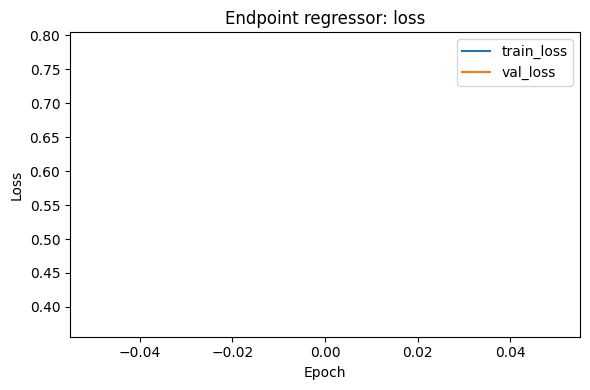

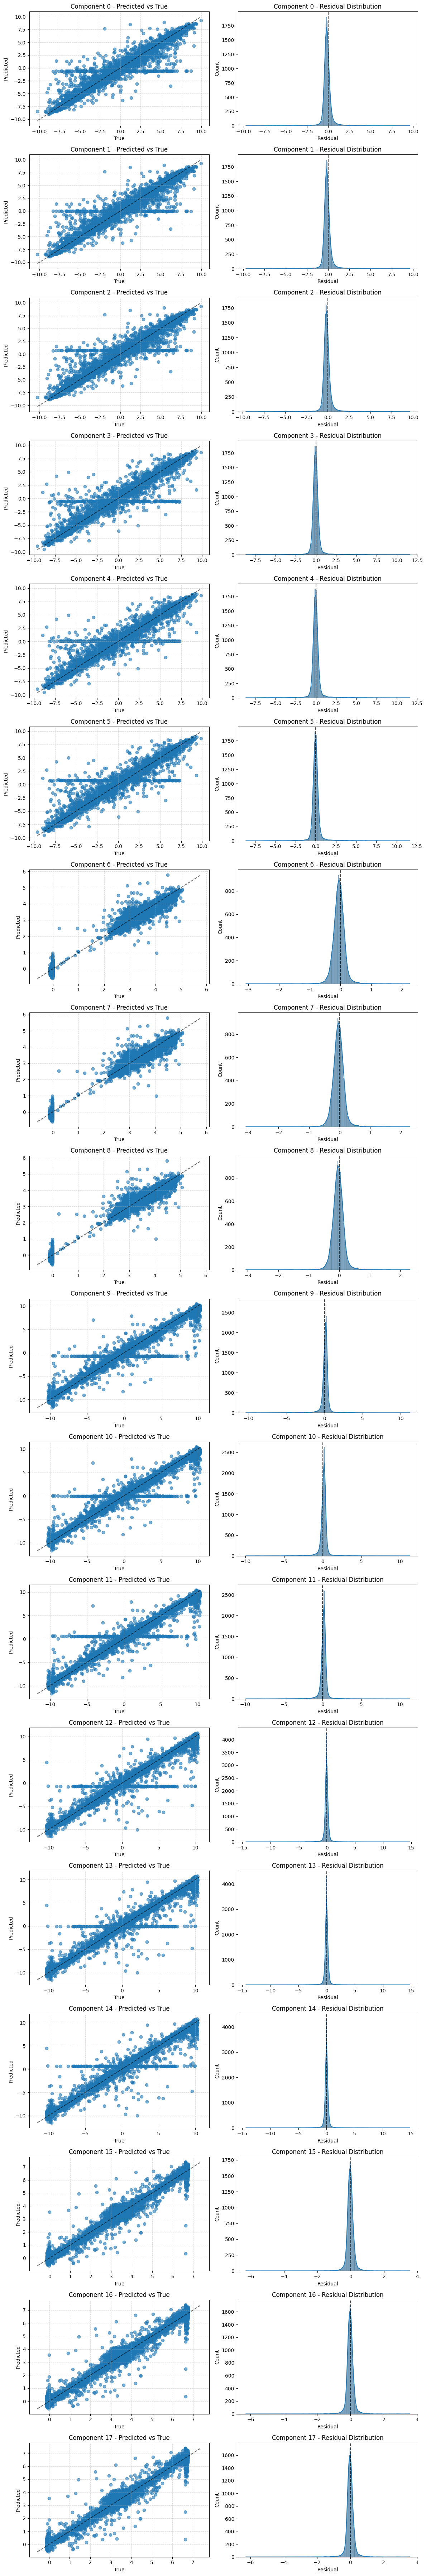

In [5]:
# Quick validation plots
from pioneerml.evaluation.plots import plot_loss_curves, plot_regression_diagnostics

plot_loss_curves(trained_module, title="Endpoint regressor: loss", show=True)
plot_regression_diagnostics(predictions=predictions, targets=targets, show=True)


In [6]:
# Save trained model + metadata
from pioneerml.metadata import TrainingMetadata, save_model_and_metadata, timestamp_now

save_ts = timestamp_now()

meta = TrainingMetadata(
    model_type="EndpointRegressor",
    timestamp=save_ts,
    run_name=run.name if 'run' in locals() else None,
    best_hyperparameters=best_params,
    best_score=best_params.get('best_score') if isinstance(best_params, dict) else None,
    n_trials=best_params.get('n_trials') if isinstance(best_params, dict) else None,
    training_config=getattr(trained_module, 'training_config', {}),
    epochs_run=getattr(trained_module, 'final_epochs_run', None),
    dataset_info={
        'train_size': len(datamodule.train_dataset) if datamodule.train_dataset else 0,
        'val_size': len(datamodule.val_dataset) if datamodule.val_dataset else 0,
    },
    model_architecture={
        'hidden': best_params.get('hidden') if isinstance(best_params, dict) else None,
        'heads': best_params.get('heads') if isinstance(best_params, dict) else None,
        'layers': best_params.get('layers') if isinstance(best_params, dict) else None,
        'dropout': best_params.get('dropout') if isinstance(best_params, dict) else None,
    },
    optuna_storage=optuna_storage,
    optuna_study_name=optuna_manager.study_name,
)

paths = save_model_and_metadata(
    model=trained_module.model,
    metadata=meta,
    state_dict_only=True,
)

print("Saved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")


Saved artifacts:
  dir: /home/jack/python_projects/pioneerML/trained_models/endpointregressor
  state_dict: /home/jack/python_projects/pioneerML/trained_models/endpointregressor/endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_state_dict.pt
  metadata: /home/jack/python_projects/pioneerML/trained_models/endpointregressor/endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_metadata.json
  full_checkpoint: /home/jack/python_projects/pioneerML/trained_models/endpointregressor/endpointregressor_20260103_124027_endpoint_optuna_pipeline-2026_01_03-12_33_04_260918_checkpoint.pt
